In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

phonert_path = '/content/gdrive/MyDrive/PhoNERT'

In [3]:
import json
import os

def load_jsonl_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
          for line in f:
              data.append(json.loads(line))
    print(f"{os.path.basename(file_path)} có {len(data)} records")
    return data

# TRAIN data
train_file_path = os.path.join(phonert_path, 'train_word.json')
train_data = load_jsonl_file(train_file_path)

# DEV data
dev_file_path = os.path.join(phonert_path, 'dev_word.json')
dev_data = load_jsonl_file(dev_file_path)

# TEST data
test_file_path = os.path.join(phonert_path, 'test_word.json')
test_data = load_jsonl_file(test_file_path)


train_word.json có 5027 records
dev_word.json có 2000 records
test_word.json có 3000 records


# 1. EDA

Các nhãn duy nhất: ['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 'I-AGE', 'I-DATE', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O']
Số lượng nhãn duy nhất: 20


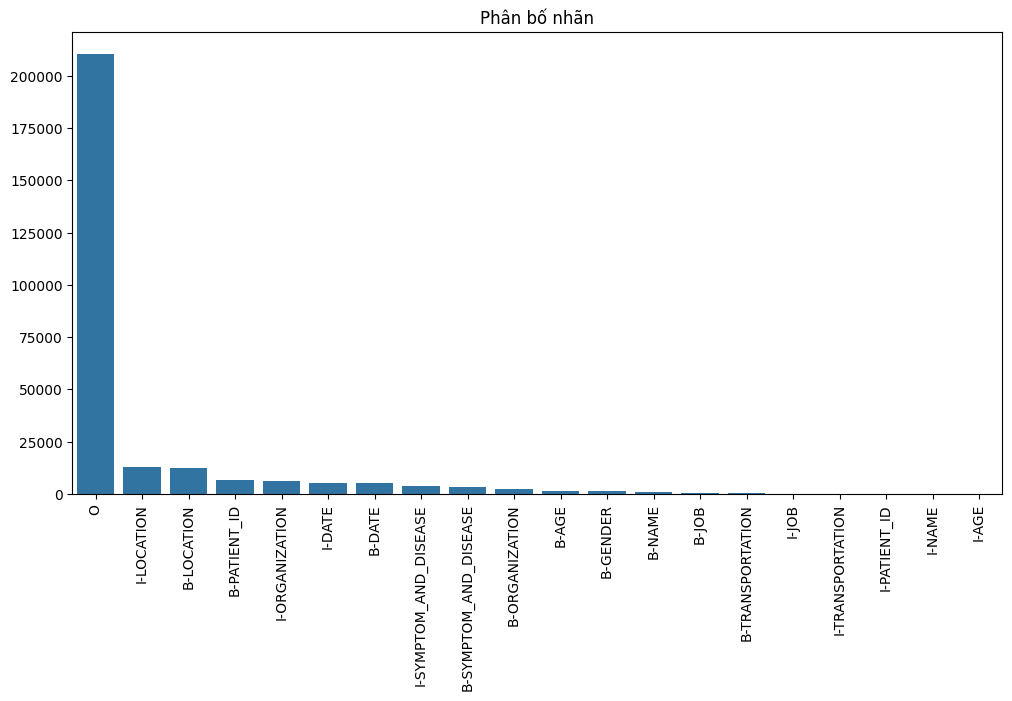

Độ dài chuỗi trung bình: 26.36
Độ dài chuỗi tối đa: 161


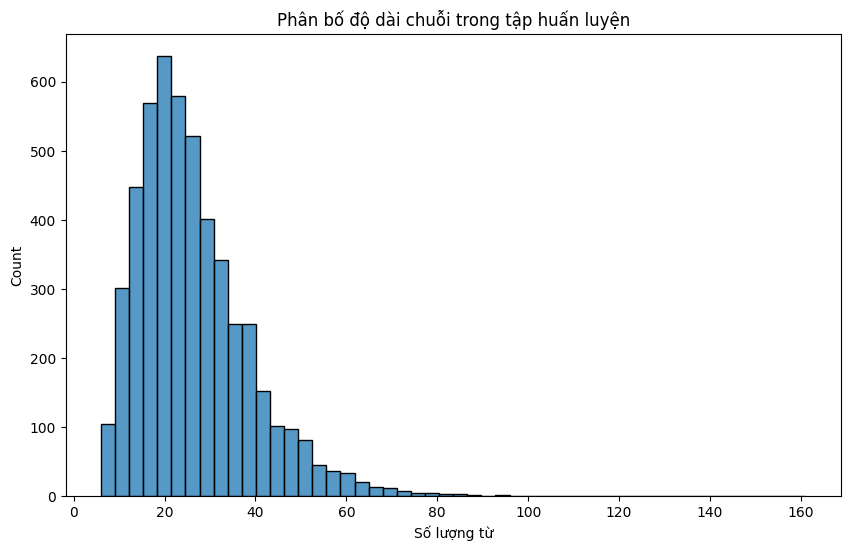

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Trích xuất các nhãn (tags) từ dữ liệu
train_tags = [item['tags'] for item in train_data]
dev_tags = [item['tags'] for item in dev_data]
test_tags = [item['tags'] for item in test_data]

# Trích xuất các từ (words) từ dữ liệu huấn luyện
train_words = [item['words'] for item in train_data]
dev_words = [item['words'] for item in dev_data] # Thêm dòng này
test_words = [item['words'] for item in test_data] # Thêm dòng này

# Lấy tất cả các nhãn duy nhất
all_tags = [tag for tags in train_tags + dev_tags + test_tags for tag in tags]
unique_tags = sorted(set(all_tags))
tag_to_id = {tag: i for i, tag in enumerate(unique_tags)}
id_to_tag = {i: tag for tag, i in tag_to_id.items()}
num_labels = len(unique_tags)
print("Các nhãn duy nhất:", unique_tags)
print("Số lượng nhãn duy nhất:", num_labels)

# Phân bố nhãn
tag_counts = Counter(all_tags)
plt.figure(figsize=(12, 6))
sns.barplot(x=[k for k, v in tag_counts.most_common()], y=[v for k, v in tag_counts.most_common()])
plt.title('Phân bố nhãn')
plt.xticks(rotation=90)
plt.show()

# Độ dài chuỗi từ
lengths = [len(words) for words in train_words]
print(f"Độ dài chuỗi trung bình: {np.mean(lengths):.2f}")
print(f"Độ dài chuỗi tối đa: {np.max(lengths)}")
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=50)
plt.title('Phân bố độ dài chuỗi trong tập huấn luyện')
plt.xlabel('Số lượng từ')
plt.show()


# 2. Huấn luyện mô hình này cho bài toán gán nhãn chuỗi trên bộ dữ liệu PhoNERT

In [6]:
!pip install transformers
!pip install seqeval

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import AutoTokenizer
import math
from seqeval.metrics import f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer (PhoBERT)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Lớp Dataset tùy chỉnh cho NER
class NERDataset(Dataset):
    def __init__(self, words_list, tags_list, tokenizer, tag_to_id, max_len=192):
        self.words_list = words_list
        self.tags_list = tags_list
        self.tokenizer = tokenizer
        self.tag_to_id = tag_to_id
        self.max_len = max_len

    def __len__(self):
        return len(self.words_list)

    def __getitem__(self, idx):
        words = self.words_list[idx]
        tags = self.tags_list[idx]

        input_ids = []
        labels = []
        attention_mask = []

        # Tokenize từng từ riêng lẻ
        for word, tag in zip(words, tags):
            word_tokens = self.tokenizer.encode(word, add_special_tokens=False)
            if word_tokens:
                input_ids.extend(word_tokens)
                labels.append(self.tag_to_id[tag])
                labels.extend([-100] * (len(word_tokens) - 1))
                attention_mask.extend([1] * len(word_tokens))

        # Thêm CLS và SEP
        input_ids = [self.tokenizer.cls_token_id] + input_ids[:self.max_len - 2] + [self.tokenizer.sep_token_id]
        labels = [-100] + labels[:self.max_len - 2] + [-100]
        attention_mask = [1] + attention_mask[:self.max_len - 2] + [1]

        # Đệm (Padding)
        padding_len = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_len
        labels += [-100] * padding_len
        attention_mask += [0] * padding_len

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Tạo các tập dữ liệu
max_len = 192
train_dataset = NERDataset(train_words, train_tags, tokenizer, tag_to_id, max_len)
dev_dataset = NERDataset(dev_words, dev_tags, tokenizer, tag_to_id, max_len)
test_dataset = NERDataset(test_words, test_tags, tokenizer, tag_to_id, max_len)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Triển khai bộ mã hóa Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = nn.functional.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.dense(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.layer_norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.layer_norm2(x + ff_output)
        return x

class TransformerEncoderNER(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=3, num_labels=20, max_len=192):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x.transpose(0, 1)).transpose(0, 1)

        mask = ~attention_mask.bool().unsqueeze(1).unsqueeze(2)

        for layer in self.layers:
            x = layer(x, mask)

        logits = self.classifier(x)
        return logits

# Khởi tạo mô hình
vocab_size = tokenizer.vocab_size
model = TransformerEncoderNER(vocab_size, num_labels=num_labels).to(device)
print(model)

# Hàm huấn luyện và đánh giá
ignore_index = -100
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        active_loss = labels.view(-1) != ignore_index
        active_logits = logits.view(-1, num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]
        loss = criterion(active_logits, active_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            active_loss = labels.view(-1) != ignore_index
            active_logits = logits.view(-1, num_labels)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = criterion(active_logits, active_labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            for p, l in zip(preds, labels_np):
                active = l != -100
                all_preds.append([id_to_tag[id] for id in p[active]])
                all_labels.append([id_to_tag[id] for id in l[active]])

    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    entity_tags = [tag for tag in unique_tags if tag != 'O']
    report = classification_report([tag for seq in all_labels for tag in seq],
                                   [tag for seq in all_preds for tag in seq],
                                   labels=entity_tags)
    return avg_loss, f1, report

# Huấn luyện mô hình
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1, _ = evaluate(model, dev_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Macro F1={val_f1:.4f}")

# Đánh giá trên tập kiểm tra
test_loss, test_f1, report = evaluate(model, test_loader, criterion, device)
print(f"Test Loss={test_loss:.4f}, Test Macro F1={test_f1:.4f}")
print(report)

TransformerEncoderNER(
  (embedding): Embedding(64000, 256)
  (pos_encoding): PositionalEncoding()
  (layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (wq): Linear(in_features=256, out_features=256, bias=True)
        (wk): Linear(in_features=256, out_features=256, bias=True)
        (wv): Linear(in_features=256, out_features=256, bias=True)
        (dense): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (classifier): Linear(in_features=256, out_features=20, bias=True)
)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 1: Train Loss=0.7901, Val Loss=0.6689, Val Macro F1=0.2185


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 2: Train Loss=0.4257, Val Loss=0.4844, Val Macro F1=0.3797


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 3: Train Loss=0.3051, Val Loss=0.4184, Val Macro F1=0.4673


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 4: Train Loss=0.2422, Val Loss=0.3897, Val Macro F1=0.5142


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 5: Train Loss=0.2011, Val Loss=0.3463, Val Macro F1=0.5908


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 6: Train Loss=0.1731, Val Loss=0.3341, Val Macro F1=0.6067


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 7: Train Loss=0.1502, Val Loss=0.3347, Val Macro F1=0.5991


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 8: Train Loss=0.1311, Val Loss=0.3338, Val Macro F1=0.6314


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 9: Train Loss=0.1132, Val Loss=0.3302, Val Macro F1=0.6419


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 10: Train Loss=0.1000, Val Loss=0.3410, Val Macro F1=0.6237


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 11: Train Loss=0.0889, Val Loss=0.3433, Val Macro F1=0.6548


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 12: Train Loss=0.0788, Val Loss=0.3551, Val Macro F1=0.6498


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 13: Train Loss=0.0747, Val Loss=0.3592, Val Macro F1=0.6613


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 14: Train Loss=0.0621, Val Loss=0.4025, Val Macro F1=0.6326


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 15: Train Loss=0.0583, Val Loss=0.3836, Val Macro F1=0.6477


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 16: Train Loss=0.0508, Val Loss=0.3930, Val Macro F1=0.6454


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 17: Train Loss=0.0459, Val Loss=0.4212, Val Macro F1=0.6583


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 18: Train Loss=0.0424, Val Loss=0.4096, Val Macro F1=0.6557


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 19: Train Loss=0.0403, Val Loss=0.4275, Val Macro F1=0.6571


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Epoch 20: Train Loss=0.0404, Val Loss=0.4203, Val Macro F1=0.6545


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss=0.4724, Test Macro F1=0.6335
                       precision    recall  f1-score   support

                B-AGE       0.68      0.80      0.74       582
               B-DATE       0.77      0.78      0.78      1654
             B-GENDER       0.90      0.91      0.90       462
                B-JOB       0.62      0.42      0.50       173
           B-LOCATION       0.78      0.75      0.76      4441
               B-NAME       0.77      0.72      0.75       318
       B-ORGANIZATION       0.73      0.72      0.73       771
         B-PATIENT_ID       0.82      0.74      0.78      2005
B-SYMPTOM_AND_DISEASE       0.84      0.72      0.78      1136
     B-TRANSPORTATION       0.89      0.76      0.82       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.81      0.72      0.77      1750
                I-JOB       0.36      0.09      0.14       114
           I-LOCATION       0.75      0.63      0.68      4918
               

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
